In [5]:
from __future__ import print_function, division


import os
import sys
sys.path.append('../..')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import copy
import json
import importlib
import glob
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from torch.optim import Adam, SGD
from losses import DiceLoss, DiceLossWithLogtis
from torch.nn import BCELoss, CrossEntropyLoss

from utils import (
    show_sbs,
    load_config,
    _print,
)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
import random
random.seed(0)
CONFIG_NAME = "isic/isic2018_unet.yaml"
CONFIG_FILE_PATH = os.path.join("../../configs", CONFIG_NAME)
config = load_config(CONFIG_FILE_PATH)
_print("Config:", "info_underline")
print(json.dumps(config, indent=2))
print(20*"~-", "\n")
# plt.ion()   # interactive mode
from datasets.isic import ISIC2018DatasetFast
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

Config:
{
  "run": {
    "mode": "train",
    "device": "gpu"
  },
  "transforms": "none",
  "dataset": {
    "class_name": "ISIC2018Dataset",
    "input_size": 224,
    "training": {
      "params": {
        "data_dir": "/raid/home/labusermodaresi/datasets/ISIC2018"
      }
    },
    "validation": {
      "params": {
        "data_dir": "/raid/home/labusermodaresi/datasets/ISIC2018"
      }
    },
    "number_classes": 2
  },
  "data_loader": {
    "train": {
      "batch_size": 16,
      "shuffle": true,
      "num_workers": 8,
      "pin_memory": true
    },
    "validation": {
      "batch_size": 16,
      "shuffle": false,
      "num_workers": 8,
      "pin_memory": true
    },
    "test": {
      "batch_size": 16,
      "shuffle": false,
      "num_workers": 4,
      "pin_memory": false
    }
  },
  "training": {
    "optimizer": {
      "name": "Adam",
      "params": {
        "lr": 0.0001
      }
    },
    "criterion": {
      "name": "DiceLoss",
      "params": {}
    },
 

In [4]:
### cell #1
import ipywidgets as widgets
import ipython_blocking # enables %block and %blockrun magic

text = widgets.Text()
dropdown = widgets.Dropdown(options=['', 'foo', 'bar', 'baz'])
button = widgets.Button(description='Run')
box = widgets.VBox(children=[text, dropdown, button])
display(box)



In [ ]:
!### cell #2
%blockrun button


Length of trainig_dataset:	1815
Length of validation_dataset:	259
Length of test_dataset:		520
torch.Size([16, 3, 224, 224])

 Training


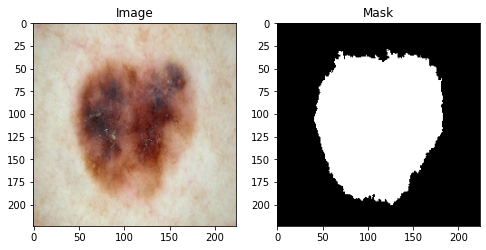

torch.Size([64, 3, 112, 112])


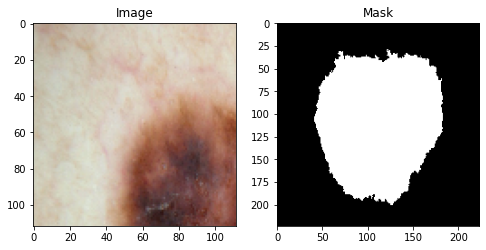

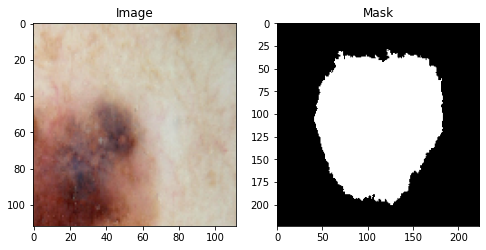

In [22]:
# ------------------- params --------------------
INPUT_SIZE = config['dataset']['input_size']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# ----------------- dataset --------------------
# preparing training dataset
tr_dataset = ISIC2018DatasetFast(mode="tr", one_hot=True)
vl_dataset = ISIC2018DatasetFast(mode="vl", one_hot=True)
te_dataset = ISIC2018DatasetFast(mode="te", one_hot=True)

# We consider 1815 samples for training, 259 samples for validation and 520 samples for testing
# !cat ~/deeplearning/skin/Prepare_ISIC2018.py

print(f"Length of trainig_dataset:\t{len(tr_dataset)}")
print(f"Length of validation_dataset:\t{len(vl_dataset)}")
print(f"Length of test_dataset:\t\t{len(te_dataset)}")


# prepare train dataloader
tr_dataloader = DataLoader(tr_dataset, **config['data_loader']['train'])

# prepare validation dataloader
vl_dataloader = DataLoader(vl_dataset, **config['data_loader']['validation'])

# prepare test dataloader
te_dataloader = DataLoader(te_dataset, **config['data_loader']['test'])

# -------------- test -----------------
# test and visualize the input data
for sample in tr_dataloader:
    img = sample['image']
    msk = sample['mask']
    print(img.shape)
    print("\n Training")
    show_sbs(img[0], msk[0,1])
    
    # Dividing each image into 16 equal parts
    num_parts = 4
    part_size = 224 // int(num_parts ** 0.5)  # Size of each part (assuming equal parts)

    # Dividing each image into parts and collecting them in a list
    divided_parts = []
    for i in range(16):
        img_parts = torch.split(img[i], part_size, dim=1)
        for part in img_parts:
            divided_parts.extend(torch.split(part, part_size, dim=2))

    # Creating the final tensor with shape (16*16, 3, part_size, part_size)
    divided_tensor = torch.stack(divided_parts, dim=0)

    # Printing the shape of the divided tensor
    print(divided_tensor.shape)
    show_sbs(divided_tensor[0], msk[0,1])
    show_sbs(divided_tensor[1], msk[0,1])
    
    break
    
# for sample in vl_dataloader:
#     img = sample['image']
#     msk = sample['mask']
#     print("Validation")
#     show_sbs(img[0], msk[0,1])
#     break
    
# for sample in te_dataloader:
#     img = sample['image']
#     msk = sample['mask']
#     print("Test")
#     show_sbs(img[0], msk[0,1])
#     break